In [48]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.model_selection import train_test_split, KFold
import statsmodels.api as sm

import sys
sys.path.append("../")

from src import modelers

plt.style.use('ggplot')

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## Prediction algorithms (supervised learning)
1. Linear Regression
2. Random Forest Regression

In [7]:
# Import data
pd.set_option("display.max_columns", 40)
data = pd.read_csv('../data/cleaned_data2.csv')
data.head()

,Unnamed: 0,state,county,fips,white_pct,black_pct,hispanic_pct,foreignborn_pct,female_pct,age29andunder_pct,age65andolder_pct,median_hh_inc,clf_unemploy_pct,lesshs_pct,lesscollege_pct,rural_pct,trump16_pct,clinton16_pct,otherpres16_pct,romney12_pct,obama12_pct,otherpres12_pct,cvap_pct12,metro,rural,urban_metroadj,urban_not_metroadj
0,0,Alabama,Autauga,1001,75.683482,18.370906,2.572254,1.838362,51.176225,40.037058,13.978456,53099.0,5.591657,12.417046,75.407229,42.002162,72.766588,23.769671,3.463741,72.618252,26.587832,0.793916,58.815434,1,0,0,0
1,1,Alabama,Baldwin,1003,83.178788,9.225603,4.366698,3.269510,51.194928,35.474412,18.714851,51365.0,6.286843,9.972418,70.452889,42.279099,76.545712,19.385601,4.068687,77.358269,21.589444,1.052286,56.228504,1,0,0,0
2,2,Alabama,Barbour,1005,45.885624,47.888329,4.309762,2.859397,46.498084,37.664387,16.528895,33956.0,12.824738,26.235928,87.132213,67.789635,52.096666,46.527844,1.375490,48.223130,51.368494,0.408376,56.485890,0,0,1,0
3,3,Alabama,Bibb,1007,74.765196,21.212121,2.223994,1.351232,46.464646,37.329435,14.885699,39776.0,7.146827,19.301587,88.000000,68.352607,76.403220,21.249575,2.347205,72.826603,26.152019,1.021378,47.868107,1,0,0,0
4,4,Alabama,Blount,1009,87.657701,1.557951,8.727298,4.271801,50.485235,37.240053,17.192916,46212.0,5.953833,19.968585,86.950243,89.951502,89.334844,8.425825,2.239331,86.465884,12.371907,1.162209,56.577893,1,0,0,0


In [8]:
# Extract our labels
trump = data.pop('trump16_pct')
clinton = data.pop('clinton16_pct')
other = data.pop('otherpres16_pct')

# Drop columns that we think are too correlated with one another
data = data.drop(columns=['Unnamed: 0', 'state', 'county', 'fips', 
                           'otherpres12_pct', 'black_pct', 'hispanic_pct'])
data2 = data.drop(columns=['obama12_pct'])
data3 = data2.drop(columns=['metro', 'rural', 'urban_metroadj', 'urban_not_metroadj'])

In [9]:
data2.columns

Index(['white_pct', 'foreignborn_pct', 'female_pct', 'age29andunder_pct',
       'age65andolder_pct', 'median_hh_inc', 'clf_unemploy_pct', 'lesshs_pct',
       'lesscollege_pct', 'rural_pct', 'romney12_pct', 'cvap_pct12', 'metro',
       'rural', 'urban_metroadj', 'urban_not_metroadj'],
      dtype='object')

In [10]:
# Make our X and y and do 75%/25% split
X = data3
y = trump

X_train, X_test, y_train, y_test = train_test_split(X, y)
X_trainn, X_testn = modelers.normalize(X_train, X_test)
rmse, r_sq, y_hat, model_coeff = modelers.lin_regression(X_trainn, X_testn, y_train, y_test)

# Keep track of indices
train_idx = X_train.index.values
test_idx = X_test.index.values

## Test toy model before using Kfold

In [22]:
rmse, r_sq, model_coeff

(3.668353211607185,
 array([0.95189087, 0.95554176, 0.9513232 , 0.9651217 , 0.95600096]),
 array([13.59624228, -3.45971239, -0.28826506, -0.2972644 ,  7.11268076,
         6.64194073, -4.06241455,  3.07788185, 31.64872126,  2.11269287,
        69.58900615, -7.96165272]))

In [21]:
# Get p-values by using stats models 
model = sm.OLS(y_train, X_trainn).fit()
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                 OLS Regression Results                                
=======================================================================================
Dep. Variable:            trump16_pct   R-squared (uncentered):                   0.997
Model:                            OLS   Adj. R-squared (uncentered):              0.997
Method:                 Least Squares   F-statistic:                          7.649e+04
Date:                Fri, 15 May 2020   Prob (F-statistic):                        0.00
Time:                        11:34:14   Log-Likelihood:                         -6081.1
No. Observations:                2333   AIC:                                  1.219e+04
Df Residuals:                    2321   BIC:                                  1.226e+04
Df Model:                          12                                                  
Covariance Type:            nonrobust                                                  
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
x1            12.1661      0.528     23.056      0.000      11.131      13.201
x2            -4.8409      0.986     -4.910      0.000      -6.774      -2.907
x3            -3.2674      1.066     -3.066      0.002      -5.357      -1.178
x4            -7.3841      1.203     -6.140      0.000      -9.743      -5.026
x5             1.4513      1.391      1.043      0.297      -1.277       4.180
x6             2.6651      0.936      2.846      0.004       0.829       4.501
x7            -5.6256      0.821     -6.852      0.000      -7.236      -4.016
x8             2.2603      0.969      2.333      0.020       0.360       4.161
x9            27.3692      0.890     30.754      0.000      25.624      29.114
x10            2.1337      0.325      6.574      0.000       1.497       2.770
x11           69.9056      0.531    131.728      0.000      68.865      70.946
x12          -10.0258      1.042     -9.617      0.000     -12.070      -7.981
==============================================================================
Omnibus:                     1005.931   Durbin-Watson:                   2.018
Prob(Omnibus):                  0.000   Jarque-Bera (JB):            12662.762
Skew:                          -1.687   Prob(JB):                         0.00
Kurtosis:                      13.903   Cond. No.                         50.4
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

## KFold with linear regression

In [30]:
fold_scores, r_sq, coeffs = modelers.kfold_scores(X_trainn, y_train, modelers.lin_regression, 5)
fold_scores, fold_scores.mean(), r_sq, r_sq.mean()

(array([3.12412879, 3.24070642, 3.19308576, 3.35646786, 3.40413703]),
 3.2637051738116925,
 array([0.95871384, 0.95295119, 0.96154637, 0.95363965, 0.95250773]),
 0.9558717551624843)

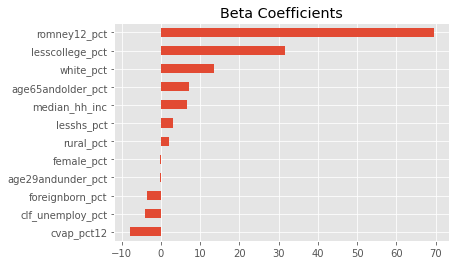

In [20]:
# Put into dataframe
coeff = pd.DataFrame(data = coeff, index=data3.columns, columns=["beta"])
coeff

# Add to df
coeff['p-values'] = model.pvalues.values
coeff = coeff.apply(lambda x: round(x,2))
coeff.sort_values(by='p-values')

# Plot these to look nice
coeff.sort_values(by='p-values')['p-values'].plot(kind='barh')
plt.title("P-values")
plt.savefig('../images/pvalues-data3.png', bbox_inches='tight', dpi=250)

coeff.sort_values(by='beta')['beta'].plot(kind='barh')
plt.title("Beta Coefficients")
plt.savefig('../images/betas_data3.png', bbox_inches='tight', dpi=250)

## Save predictions

In [47]:
predictions = pd.DataFrame({'index_values': test_idx, 'trump_predict': y_hat, 'trump_true': y_test, 
              'clinton_predict': 100-y_hat, 'clinton_true': 100-y_test})
predictions.to_csv('../data/predictions.csv')

## Random Forest Regressor

In [41]:
# Get model predictions
rmse, r_sq, y_hat, coeff = modelers.random_forest(X_trainn, X_testn, y_train, y_test)

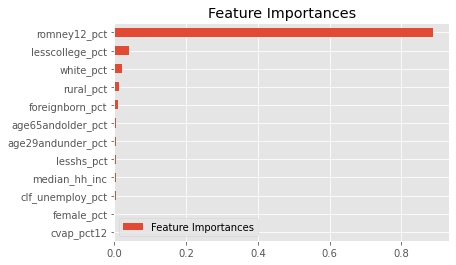

In [46]:
# Put into dataframe
coeff = pd.DataFrame(data = coeff, index=data3.columns, columns=["Feature Importances"])

# Plot these to look nice
coeff.sort_values(by='Feature Importances').plot(kind='barh')
plt.title("Feature Importances")
plt.savefig('../images/featureimportRF-data3.png', bbox_inches='tight', dpi=250)

In [40]:
# Check model
rmse, r_sq, coeff = modelers.kfold_scores(X_trainn, y_train, modelers.random_forest, 5)
rmse, r_sq, rmse.mean(), r_sq.mean()

(array([2.93519706, 3.12009867, 3.17640136, 2.79402972, 3.32850039]),
 array([0.96177274, 0.96175679, 0.96035591, 0.9663803 , 0.95510705]),
 3.0708454402708876,
 0.9610745600047441)

In [38]:
# Save predictions
predictions = pd.DataFrame({'index_values': test_idx, 'trump_predict': y_hat, 'trump_true': y_test, 
              'clinton_predict': 100-y_hat, 'clinton_true': 100-y_test})
predictions.to_csv('../data/predictions_RF.csv')

## Gradient Boosting Regressor

In [55]:
# Get model predictions
rmse, r_sq, y_hat, coeff = modelers.gradient_boosting(X_trainn, X_testn, y_train, y_test)

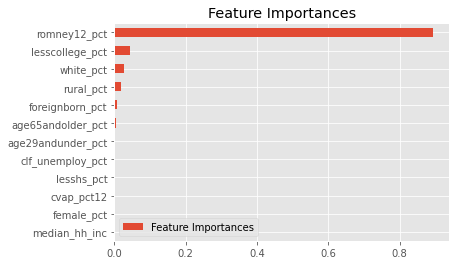

In [56]:
# Put into dataframe
coeff = pd.DataFrame(data = coeff, index=data3.columns, columns=["Feature Importances"])

# Plot these to look nice
coeff.sort_values(by='Feature Importances').plot(kind='barh')
plt.title("Feature Importances")
plt.savefig('../images/featureimportGB-data3.png', bbox_inches='tight', dpi=250)

In [52]:
# Check model
rmse, r_sq, coeff = modelers.kfold_scores(X_trainn, y_train, modelers.random_forest, 5)
rmse, r_sq, rmse.mean(), r_sq.mean()

(array([3.03573677, 2.9861384 , 3.80587526, 2.63016817, 2.79205456]),
 array([0.96173836, 0.96298112, 0.94003491, 0.97258808, 0.96700609]),
 3.049994631196237,
 0.9608697112006391)

In [53]:
# Save predictions
predictions = pd.DataFrame({'index_values': test_idx, 'trump_predict': y_hat, 'trump_true': y_test, 
              'clinton_predict': 100-y_hat, 'clinton_true': 100-y_test})
predictions.to_csv('../data/predictions_GB.csv')